In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as xgb

import warnings
warnings.filterwarnings("ignore")


In [7]:
crd_data = pd.read_csv("C:\\Users\\ASUS\\OneDrive\\Desktop\\creadit_card.csv")
crd_data.head()
print(crd_data)

       person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \

In [8]:
# Understanding the dataset
crd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [9]:
# Checking for Duplicate and missing values
print("Duplicate Rows:", len(crd_data) - len(crd_data.drop_duplicates()))
print("Null Rows:", crd_data.isnull().all(axis = 1).sum())

Duplicate Rows: 165
Null Rows: 0


In [10]:
# Summary Stats
crd_data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.794357,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.228789,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,156.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [11]:
# Unique values per column
crd_data.nunique()


person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               37
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  348
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

In [12]:
# Percentage of Missing Values
null_rows = pd.DataFrame(crd_data.isnull().sum(), columns = ['Count'])
null_rows['Perc'] = round(crd_data.isnull().sum()/crd_data.shape[0] * 100,2)
null_rows

,Count,Perc
person_age,0,0.00
person_income,0,0.00
person_home_ownership,0,0.00
person_emp_length,895,2.75
loan_intent,0,0.00
loan_grade,0,0.00
loan_amnt,0,0.00
loan_int_rate,3116,9.56
loan_status,0,0.00
loan_percent_income,0,0.00


In [13]:
# Removing missing and duplicate data
crd_data.dropna(inplace = True)
crd_data.drop_duplicates(inplace = True)

# Filling missing values in columns
crd_data['person_emp_length'].fillna(crd_data['person_emp_length'].median())
crd_data['loan_int_rate'].fillna(crd_data['loan_int_rate'].mean())

# Saving changes
cleaned_df = crd_data.copy()

# Checking for missing values
cleaned_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [14]:
# Encoding categorical Data
categorical = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']

for col in categorical:
    le = LabelEncoder()
    cleaned_df[col] = le.fit_transform(cleaned_df[col])

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28501 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28501 non-null  int64  
 1   person_income               28501 non-null  int64  
 2   person_home_ownership       28501 non-null  int32  
 3   person_emp_length           28501 non-null  float64
 4   loan_intent                 28501 non-null  int32  
 5   loan_grade                  28501 non-null  int32  
 6   loan_amnt                   28501 non-null  int64  
 7   loan_int_rate               28501 non-null  float64
 8   loan_status                 28501 non-null  int64  
 9   loan_percent_income         28501 non-null  float64
 10  cb_person_default_on_file   28501 non-null  int32  
 11  cb_person_cred_hist_length  28501 non-null  int64  
dtypes: float64(3), int32(4), int64(5)
memory usage: 2.4 MB


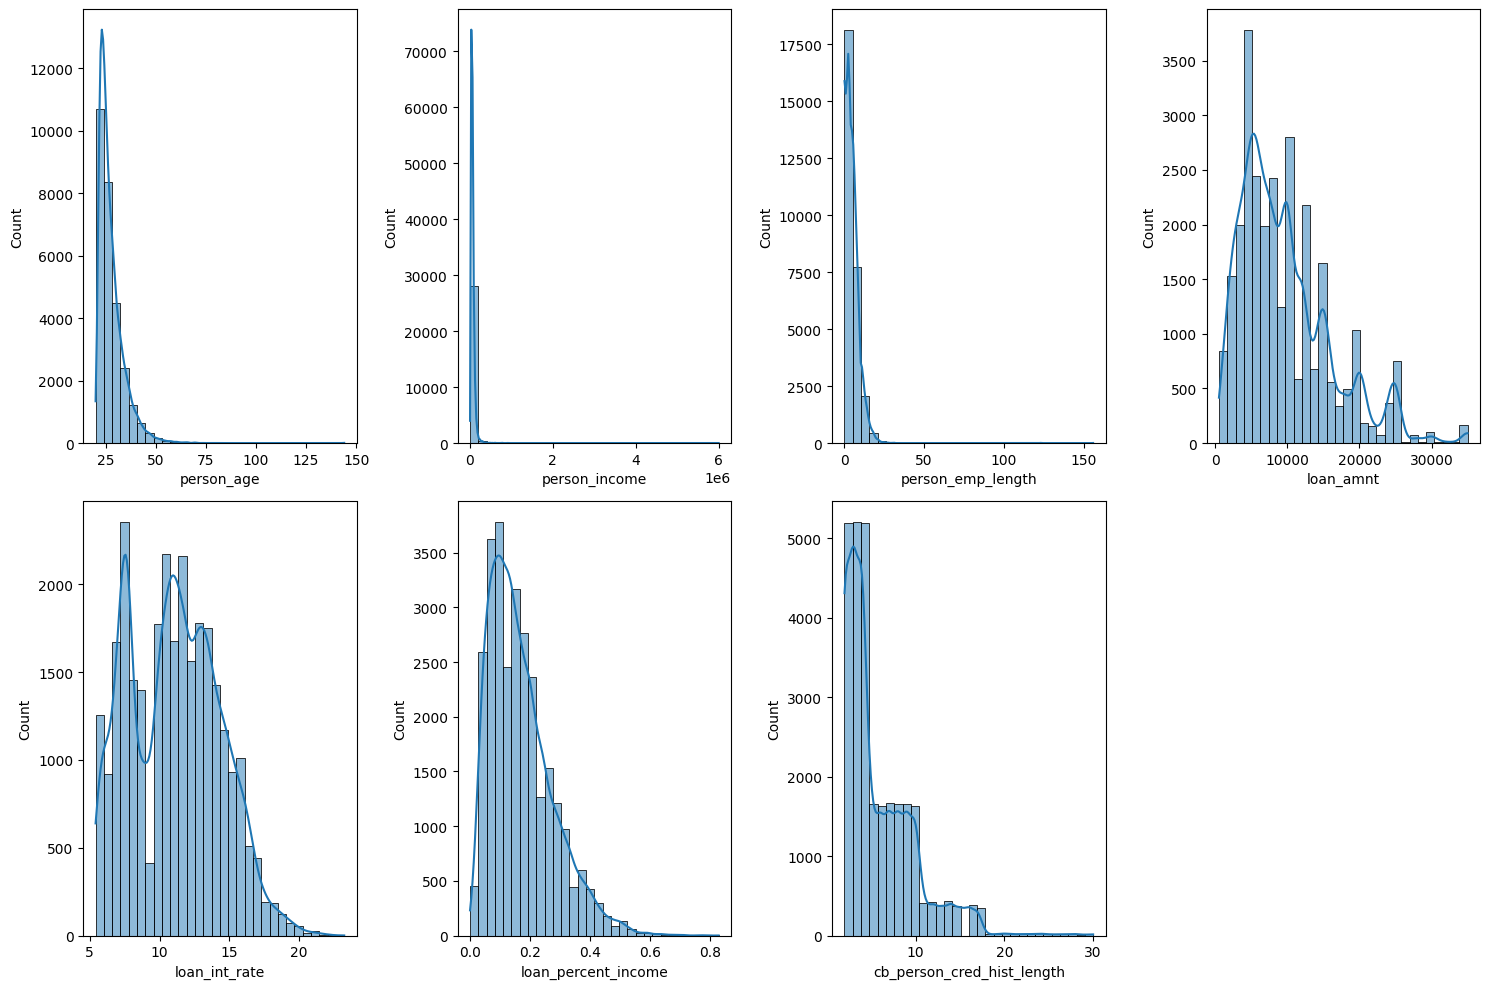

In [15]:
# Understanding Continous Data
continous = ['person_age', 'person_income','person_emp_length', 'loan_amnt','loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

fig,ax = plt.subplots(nrows = 2, ncols = 4, figsize = (15,10))

for i, col in enumerate(continous):
    sns.histplot(data = cleaned_df, x = col, kde = True, bins = 30, ax = ax[i//4,i%4])

fig.delaxes(ax[1,3])
plt.tight_layout()
plt.show()

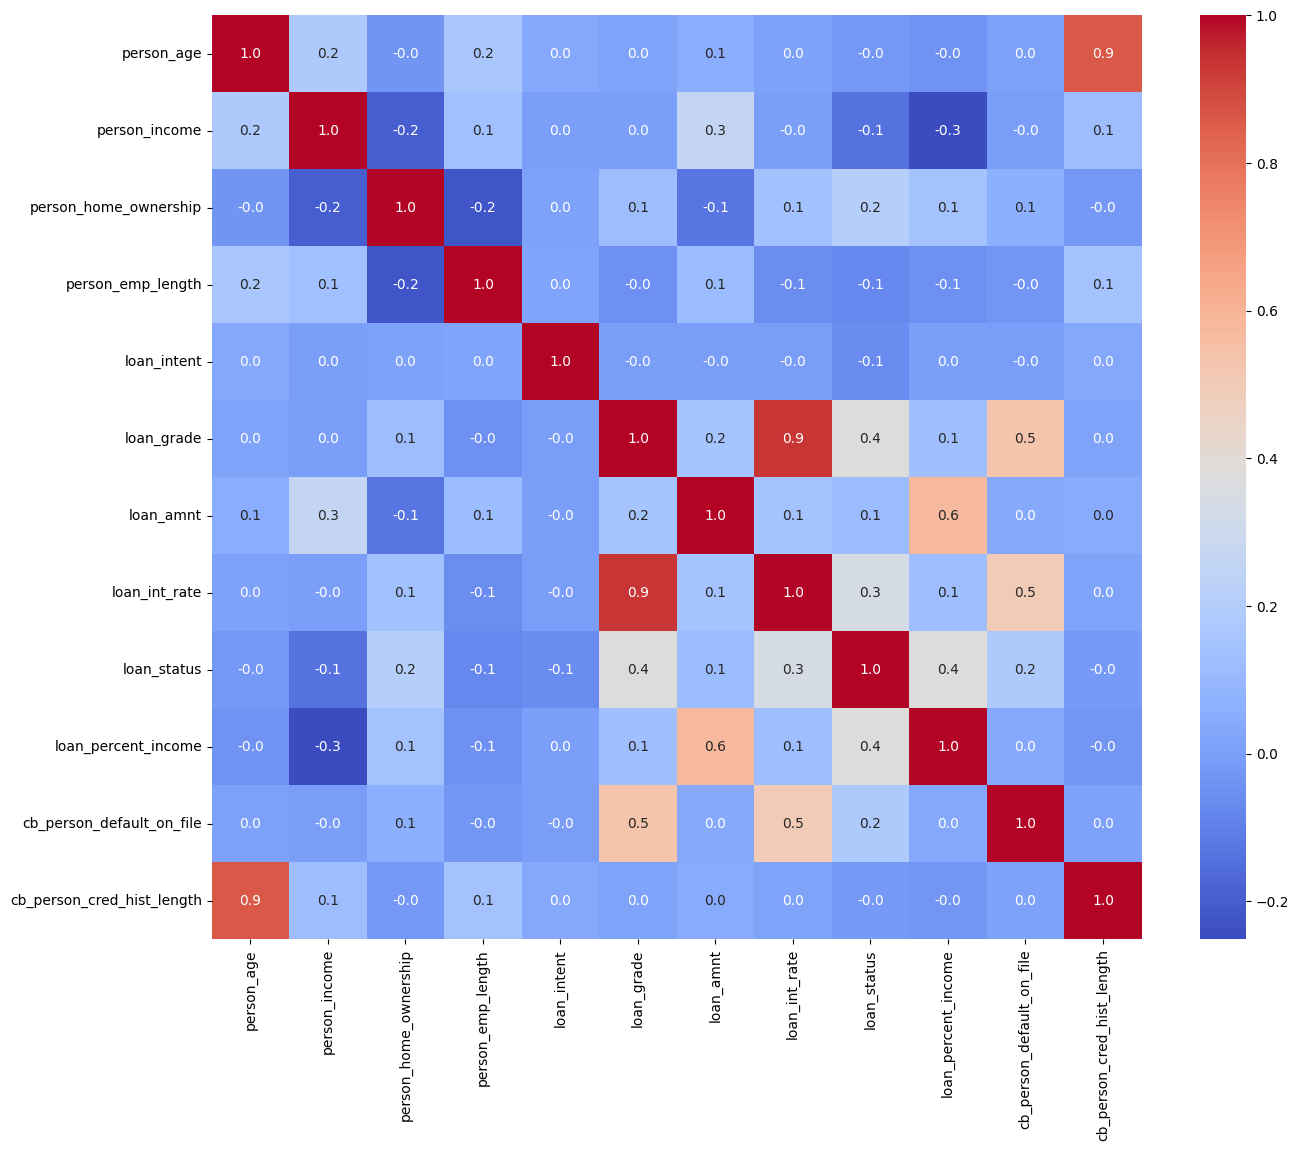

In [16]:
# Understanding correlation between columns
corr_matrix = cleaned_df.corr()

plt.figure(figsize = (15,12))
sns.heatmap(corr_matrix, annot = True, fmt = '.1f', cmap = "coolwarm")
plt.show()

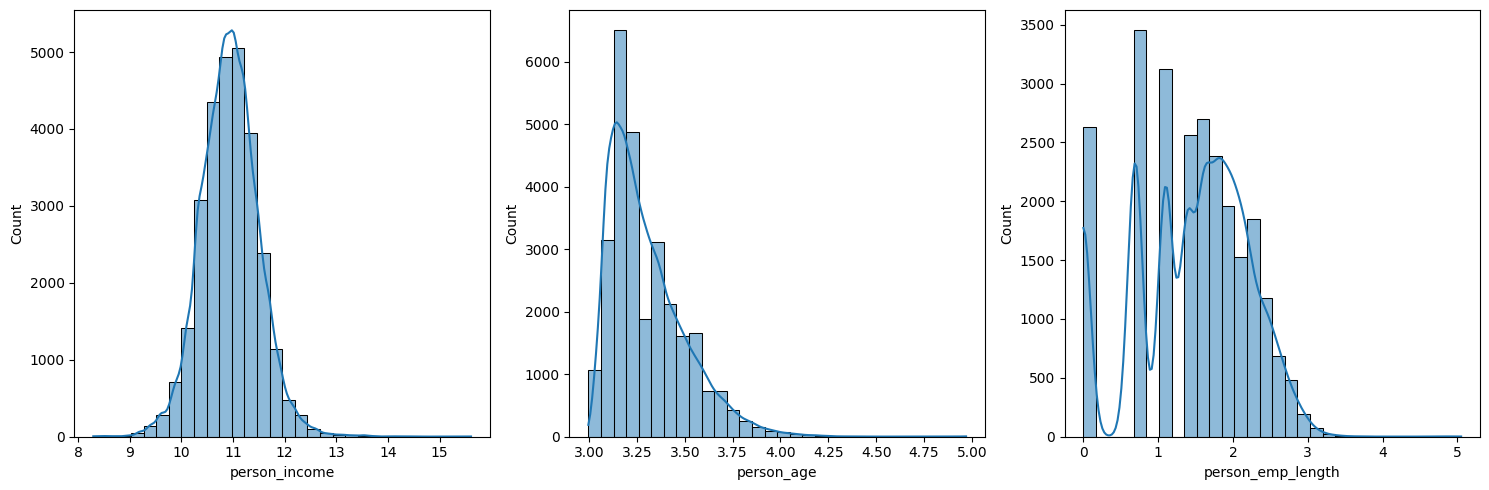

In [17]:
# Understanding Log Data Distribution of Income, Age, Employement Length

plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
sns.histplot(x=np.log(cleaned_df['person_income']), bins=30, kde = True)

plt.subplot(1,3,2)
sns.histplot(x=np.log(cleaned_df['person_age']), bins=30, kde = True)

plt.subplot(1,3,3)
sns.histplot(x=np.log(cleaned_df['person_emp_length']), bins=30, kde = True)

plt.tight_layout()
plt.show()


Class Imbalance Ratio: 0.2773271187200287


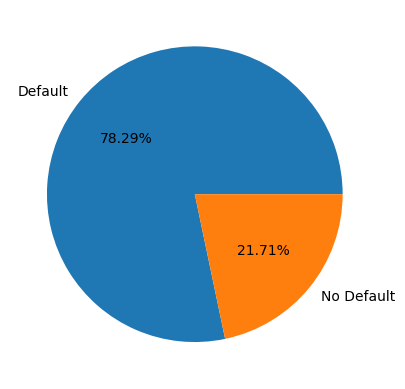

In [18]:
# Understanding Class Imbalance Ratio

status = cleaned_df['loan_status'].value_counts()
print("Class Imbalance Ratio:", status[1]/status[0])
plt.pie(status, autopct = '%.2f%%', labels = ["Default","No Default"])
plt.show()

In [19]:
# Logarthmic Scaling for skewed data
preprocess_df = cleaned_df.copy()

preprocess_df['income_log'] = round(np.log(preprocess_df['person_income']+1),2)
preprocess_df['age_log'] = round(np.log(preprocess_df['person_age']+1),2)
preprocess_df['emp_length_log'] = round(np.log(preprocess_df['person_emp_length']+1),2)

preprocess_df.drop(columns = ['person_income','person_age','person_emp_length'], inplace = True)

preprocess_df.head()


,person_home_ownership,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_log,age_log,emp_length_log
0,3,4,3,35000,16.02,1,0.59,1,3,10.99,3.14,4.82
1,2,1,1,1000,11.14,0,0.10,0,2,9.17,3.09,1.79
2,0,3,2,5500,12.87,1,0.57,0,3,9.17,3.26,0.69
3,3,3,2,35000,15.23,1,0.53,0,2,11.09,3.18,1.61
4,3,3,2,35000,14.27,1,0.55,1,4,10.90,3.22,2.20


In [20]:
# Splitting the data
X = preprocess_df.drop('loan_status', axis = 1)
y = preprocess_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(22800, 11)
(5701, 11)
(22800,)
(5701,)


In [21]:
# Preparing the model evaluator
def model_evaluator(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print("Results:\n")
    print("ROC AUC Score: ", roc_auc_score(y_test, y_preds),'\n')
    print(classification_report(y_test, y_preds))
    
    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot(cmap = 'Blues')
    
    classes = ['Default', 'No Default']
    plt.xticks([0,1],classes)
    plt.yticks([0,1],classes)

Results:

ROC AUC Score:  0.7112237877211982 

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4441
           1       0.73      0.47      0.57      1260

    accuracy                           0.85      5701
   macro avg       0.80      0.71      0.74      5701
weighted avg       0.84      0.85      0.83      5701



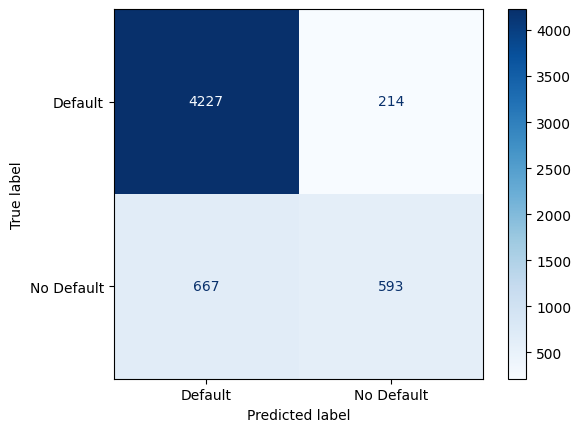

In [22]:
# Logistic Regression Model Results
model_evaluator(LogisticRegression(), X_train_scaled, X_test_scaled, y_train, y_test)


Results:

ROC AUC Score:  0.8414636521875882 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4441
           1       0.97      0.69      0.81      1260

    accuracy                           0.93      5701
   macro avg       0.94      0.84      0.88      5701
weighted avg       0.93      0.93      0.92      5701



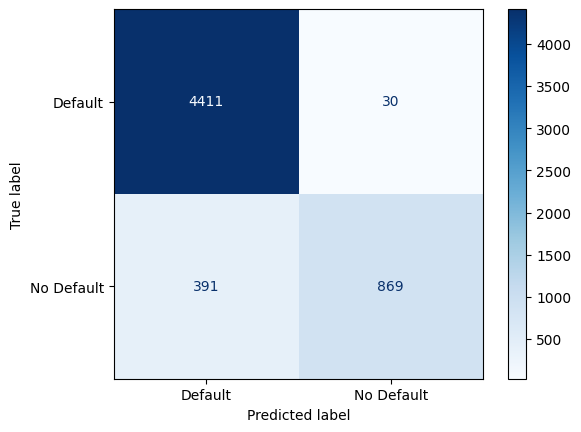

In [23]:
# Random Forest Classifier Model Results
model_evaluator(RandomForestClassifier(),X_train_scaled, X_test_scaled, y_train, y_test)

Results:

ROC AUC Score:  0.8025694020008364 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4441
           1       0.66      0.71      0.68      1260

    accuracy                           0.86      5701
   macro avg       0.79      0.80      0.80      5701
weighted avg       0.86      0.86      0.86      5701



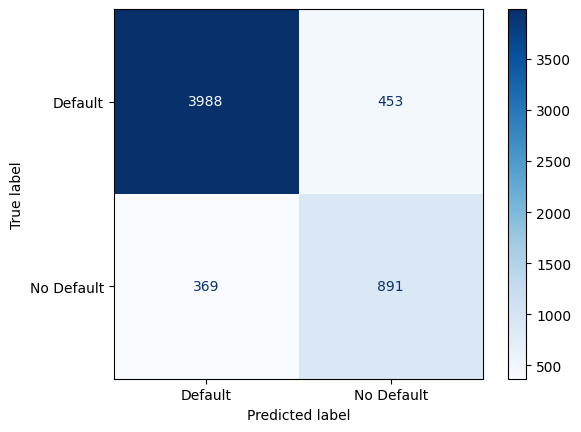

In [24]:
# XGBoost Classifier Model Results
model_evaluator(xgb(), X_train_scaled, X_test_scaled, y_train, y_test)

Best Params:  {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}
Best ROC AUC 0.9449325547108208
Results:

ROC AUC Score:  0.8074530975791953 

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      4441
           1       0.69      0.70      0.70      1260

    accuracy                           0.87      5701
   macro avg       0.80      0.81      0.81      5701
weighted avg       0.87      0.87      0.87      5701



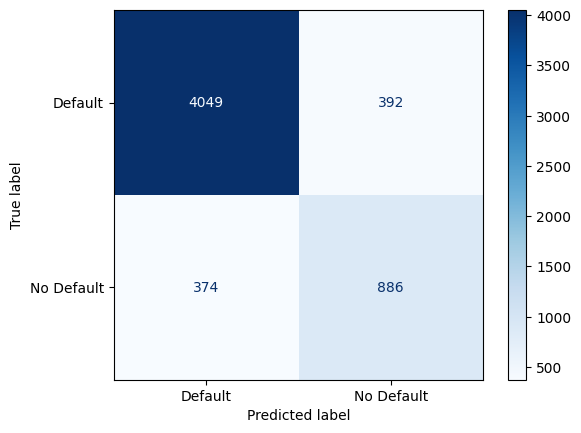

In [25]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.01, 0.1, 0.5],
    'min_child_weight' : [1,3,5],
    'max_depth' : [3,4,5]
}

grid_search = GridSearchCV(estimator = xgb(), param_grid = param_grid, scoring = 'roc_auc', cv = 3, n_jobs = -1)
grid_search.fit(X_train_scaled, y_train)

print("Best Params: ", grid_search.best_params_)
print("Best ROC AUC", grid_search.best_score_)

best_model = grid_search.best_estimator_
model_evaluator(best_model, X_train_scaled, X_test_scaled, y_train, y_test)

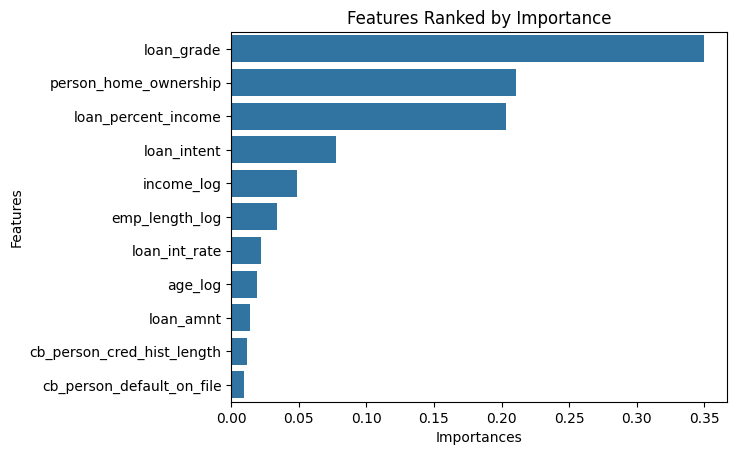

In [26]:
# Plotting feature importance on bar plot
feature_importance = pd.DataFrame({
    'Features': X.columns,
    'Importances': best_model.feature_importances_
})

feature_importance.sort_values('Importances', ascending = False, inplace = True)

sns.barplot(x = 'Importances', y = 'Features', data = feature_importance)
plt.title("Features Ranked by Importance")
plt.show()

In [27]:
#conclusion

#This project was done to find out the potential credit risk given their demographics, credit history, loan information.
#EDA showed heavily skewed data for age, income, employement length, so used the log transformation on it.
#Also found out class imbalance ratio was 27.7% which represents the lower class pretty well so didnt make much changes to it.
#Loan Grade has the highest affect on the credit risk. Following closely are home ownership and loan percentage of income,
#                                     suggesting that these factors influence the risk of default on the loan heavily.